In [1]:
import os

if 'main_dir' in globals():
    os.chdir(main_dir)

import pandas as pd
from utils.load_config import (
    load_exp_config, 
    get_value_from_fields, 
    get_df_historical_data,
    get_list_historical_data
    )

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
# plt.style.use("tableau-colorblind10")
plt.style.use("seaborn-v0_8-whitegrid")

from regelum.objective import RunningObjective
from regelum.model import ModelQuadLin
import numpy as np


if os.getcwd().endswith("notebooks"):
    main_dir = os.getcwd()
    os.chdir("..")

In [2]:
try:
    from src.objective import ThreeWheeledRobotCostWithSpot
except:
    from src.objective import ThreeWheeledRobotCostWithSpot

In [3]:
import sys, traceback

objective_function = RunningObjective(ModelQuadLin(
    weights= [2, 10, 0, 0, 0],
    quad_matrix_type="diagonal",
    is_with_linear_terms=False,
))

objective_function = ThreeWheeledRobotCostWithSpot(
    quadratic_model=ModelQuadLin(
        weights= [100, 100, 0, 0, 0],
        quad_matrix_type="diagonal",
        is_with_linear_terms=False),
        spot_gain=100,
        spot_x_center=-0.5,
        spot_y_center=-0.5,
        spot_std=0.2,
    )


def get_sampling_time(exp_path):
    config = load_exp_config(exp_path)

    sampling_time = config['scenario']['sampling_time']
    if "$" in sampling_time:
        correct_fields = sampling_time.strip("\{\}$").split(".")
        sampling_time = get_value_from_fields(config, correct_fields)

    return sampling_time

def cal_obj_df(row):
    observation = np.expand_dims(np.array(row.loc[["x [m]", "y [m]", "angle [rad]"]].values, dtype=np.float32), axis=0)
    action = np.expand_dims(np.array(row.loc[["velocity [m/s]", "angular velocity [rad/s]"]].values, dtype=np.float32), axis=0)

    try:
        return objective_function(observation, action)
    except Exception as err:
        print("Error:", err)
        traceback.print_exc(file=sys.stdout)
        
        raise err
    
def correct_column_name(df):
    replacements = {
        "x_rob"   :     "x [m]", 
        "y_rob"   :    "y [m]",
        "vartheta":       "angle [rad]",
        "v"       : "velocity [m/s]",
        "omega"   :    "angular velocity [rad/s]",
    }

    new_columns = []
    if "x [m]" not in df.columns.values:
        for col in df.columns.values:
            new_columns.append(col if col not in replacements else replacements[col])

        df.columns = new_columns
    
    return df

In [4]:
class ExperimentData():
    def __init__(self, exp_path, chosen_name, **kwarg) -> None:
        self.df = get_df_historical_data(exp_path=exp_path, chosen_name=chosen_name)
        self.sampling_time = get_sampling_time(exp_path)
        self.color = kwarg.get("color")
        
        self.df = correct_column_name(self.df)
        self.calculate_objective_values()
    
    def prepare_df(self, **kwarg):
        self.df = get_df_historical_data(kwarg.get("exp_path"), kwarg.get("chosen_name"))
    
    def calculate_objective_values(self):
        self.df["objective_value"] = self.df.apply(cal_obj_df, axis=1)
        self.df["accumulative_objective"] = self.df["objective_value"].apply(lambda x: x*self.sampling_time).cumsum()

    def plot_cost(self, ax, exp_name="", with_others=False):
        titles = [
            "Objective value",
            "Accumulative objective value"
        ]
        targets = [
            "objective_value",
            "accumulative_objective"
        ]
        if not with_others:
            titles[0] += "of {} \n final cost: {:0.2f}".format(exp_name, self.df.accumulative_objective.max())
            titles[1] += "of {} \n final cost: {:0.2f}".format(exp_name, self.df.accumulative_objective.max())

        for i in range(len(titles)):
            ax[i].set_title(titles[i])
            self.df.plot(x="time", y=targets[i], ax=ax[i], label=exp_name if with_others else None, alpha=0.8, color=self.color)
            ax[i].grid()

    def plot_trajectory(self, ax, exp_name=""):
        ax.set_title("Trajectory")
        ax.plot(self.df["x [m]"], self.df["y [m]"], label=exp_name, alpha=0.8, color=self.color)
        ax.grid()
    

In [5]:
experiment_collections = {
    "CALF controller": {
        "exp_path": "/home/robosrv/huyhoang/regelum-playground/regelum_data/outputs/2024-08-20/15-51-23/0",
        "chosen_name": "observations_actions_it_00001"
    },
    "MPC controller": {
        "exp_path": "/home/robosrv/huyhoang/regelum-playground/regelum_data/outputs/2024-08-20/15-53-14/0",
        "chosen_name": "observations_actions_it_00001"
    },
    "SARSA_m controller": {
        "exp_path": "/home/robosrv/huyhoang/regelum-playground/regelum_data/outputs/2024-08-20/15-56-16/0",
        "chosen_name": "observations_actions_it_00001"
    },
    "Nominal controller": {
        "exp_path": "/home/robosrv/huyhoang/regelum-playground/regelum_data/outputs/2024-08-20/15-59-31/0",
        "chosen_name": "observations_actions_it_00001"
    },
    "PPO controller": {
        "exp_path": "/home/robosrv/huyhoang/regelum-playground/regelum_data/outputs/2024-08-20/16-01-28/0",
        "chosen_name": "observations_actions_it_00001"
    },
}

cm = plt.get_cmap("tab10")

color_values = np.linspace(0, 1, 10)

for idx, exp_n in enumerate(experiment_collections):
    experiment_collections[exp_n]["color"] = cm(color_values[idx])
    experiment_collections[exp_n]["obj"] = ExperimentData(**experiment_collections[exp_n])


## Re-calculate objective

### Define objective function

In [6]:

observation = np.array([[1, 1, 0.01]])
actions = np.array([[1, 1]])
objective_function(observation, actions)

200.0

## Plot objective

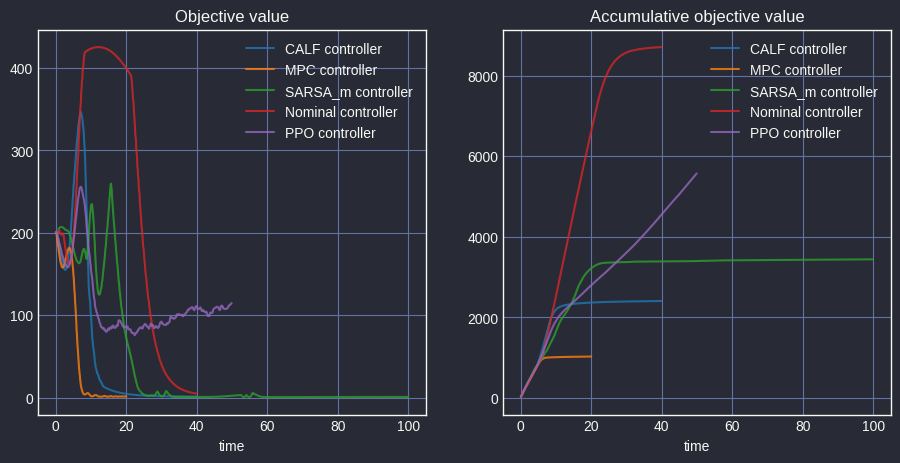

In [7]:
%matplotlib inline
plt.clf()
fig, ax = plt.subplots(1, 2, figsize=(11, 5))

for id, exp_n in enumerate(experiment_collections):
    experiment_collections[exp_n]["obj"].plot_cost(ax, exp_n, with_others=True)

for _ax in ax:
    _ax.grid()
# ppo_exp.plot_cost(ax[0], "PPO Controller")
# nominal_exp.plot_cost(ax[1], "Nominal Controller")

In [8]:
def get_cost_map(x_lim, y_lim):
    X = np.arange(x_lim[0], x_lim[1], 0.01)
    Y = np.arange(y_lim[0], y_lim[1], 0.01)

    X, Y = np.meshgrid(X, Y)
    Z = []
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Z.append(objective_function(observation=np.array([[X[i, j], Y[i, j], 0]]),
                                        action=np.array([[0, 0]])))

    Z = np.array(Z).reshape((X.shape[0], X.shape[1]))
    
    return X, Y, Z
X, Y, Z = get_cost_map([-1.7, 0.3], [-1.7, 0.3])

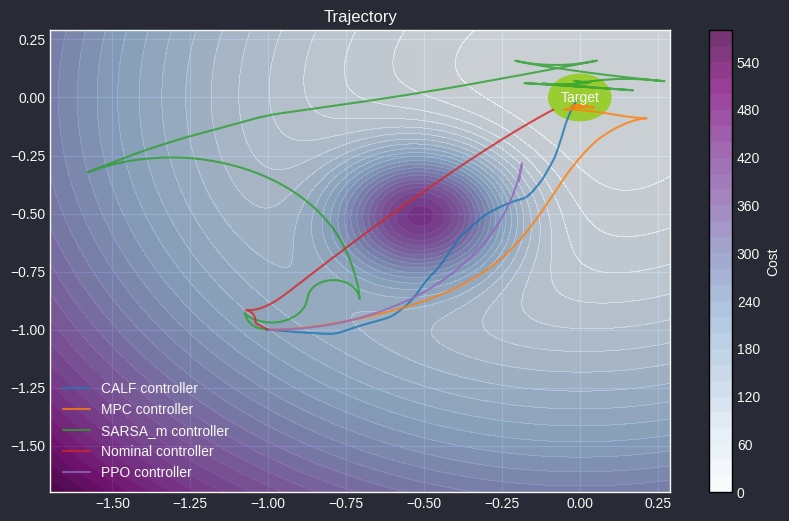

In [9]:
%matplotlib inline
plt.clf()
fig, ax = plt.subplots(figsize=(10, 6))

plt.figure(facecolor='white')  # Set figure background color
plt.rcParams.update({"figure.figsize" : (12, 8),
                     "axes.facecolor" : "white",
                     "axes.edgecolor":  "black"})

cs = ax.contourf(X, Y, Z, alpha=0.8, levels=35, cmap="BuPu")
cs.cmap.set_over('red')
cs.cmap.set_under('blue')
cs.changed()

# Make a colorbar for the ContourSet returned by the contourf call.
cbar = fig.colorbar(cs)
cbar.ax.set_ylabel('Cost')

for id, exp_n in enumerate(experiment_collections):
    experiment_collections[exp_n]["obj"].plot_trajectory(ax, exp_n)

ax.annotate(text="Target", xy=(0, 0), ha='center', va='center')
goal_circle = plt.Circle((0, 0), 0.1, color="yellowgreen")
ax.add_artist(goal_circle)

ax.grid()
ax.legend()

In [10]:
np.min(Z), np.max(Z)
Z = np.where(Z<1,np.zeros_like(Z), Z)

# Check log to plot Cost in a CI

In [11]:
import os
from datetime import datetime
import pathlib

In [12]:
ROOT_DIR = "./regelum_data/outputs/"

start_datetime_str = "2024-08-21 16-45-08"
end_datetime_str = "2024-08-22 16-45-08"
date_format = '%Y-%m-%d %H-%M-%S'

In [13]:
def get_df_from_datetime_range(start_datetime_str, end_datetime_str, date_format='%Y-%m-%d %H-%M-%S', decay_rate=1):
    start_date_time = datetime.strptime(start_datetime_str, date_format)
    end_date_time = datetime.strptime(end_datetime_str, date_format)
    date_folder = os.listdir(ROOT_DIR)

    valid_paths = []
    for d in date_folder:
        for t in os.listdir(os.path.join(ROOT_DIR, d)):
            tmp_datetime = datetime.strptime(f"{d} {t}", date_format)
            if tmp_datetime < start_date_time or end_date_time < tmp_datetime:
                continue

            valid_paths.append(str(pathlib.Path(os.path.join(ROOT_DIR, d, t)).absolute()))

    path_hierachy = {}
    for p in valid_paths:
        path_hierachy[p] = get_list_historical_data(p)

    total_dfs = []
    for exp_path in path_hierachy:
        exp_dfs = []
        for iteration_path in path_hierachy[exp_path]:
            exp_dfs.append(get_df_historical_data(absolute_path=iteration_path))
            exp_dfs[-1]["absolute_path"] = iteration_path
            exp_dfs[-1] = correct_column_name(exp_dfs[-1])
            exp_dfs[-1]["objective_value"] = exp_dfs[-1].apply(cal_obj_df, axis=1)
            # exp_dfs[-1]["accumulative_objective"] = exp_dfs[-1]["objective_value"].apply(lambda x: x*0.1).cumsum()
            exp_dfs[-1]["accumulative_objective"] = exp_dfs[-1].apply(lambda x: x["objective_value"]*0.1*decay_rate**x["time"], axis=1).cumsum()
        
        if len(exp_dfs) == 0:
            continue
        
        exp_df = pd.concat(exp_dfs)
        exp_df.sort_values(by=["iteration_id", "time"], inplace=True)
        exp_df["experiment_path"] = exp_path
        
        total_dfs.append(exp_df)

    total_df = pd.concat(total_dfs)

    # Post process
    total_df = total_df[total_df.iteration_id <= 100]
    
    return total_df

In [14]:
from scipy.interpolate import interp1d

ALPHA=0.2
N_SAMPLE_INTER=5000
USE_INTERPOLATE=True

def plot_cost_ic_learning_curve(df, ax, low_quantile=0.025, high_quantile=0.975, color=None, use_interpolate=USE_INTERPOLATE):
   def quantile_low(series):
      return series.quantile(low_quantile)

   def quantile_high(series):
      return series.quantile(high_quantile)

   group_df = df.groupby(["experiment_path", "iteration_id"]).last()
   ic_95_df = group_df.groupby("iteration_id").agg({"accumulative_objective": [quantile_low, quantile_high]})

   # Plot
   if not use_interpolate:
      X_ = ic_95_df.index
      Y_hi = ic_95_df.accumulative_objective.quantile_high
      Y_lo = ic_95_df.accumulative_objective.quantile_low
   else:
      cubic_interpolation_model_hi = interp1d(ic_95_df.index, 
                                             ic_95_df.accumulative_objective.quantile_high, kind = "cubic")
      
      cubic_interpolation_model_lo = interp1d(ic_95_df.index, 
                                             ic_95_df.accumulative_objective.quantile_low, kind = "cubic")
   
      # Plotting the Graph
      X_=np.linspace(ic_95_df.index.min(), ic_95_df.index.max(), N_SAMPLE_INTER)
      Y_hi=cubic_interpolation_model_hi(X_)
      Y_lo=cubic_interpolation_model_lo(X_)
   
   p = ax.fill_between(X_, 
                       Y_hi, Y_lo, 
                       facecolor=color,
                       alpha=0.5)
   
   ax.set_xlabel("Iterations")
   ax.set_ylabel("Accumulated Objectives")

   return p

def plot_cost_median_learning_curve(df, ax, color=None, use_interpolate=USE_INTERPOLATE):
   group_df = df.groupby(["experiment_path", "iteration_id"]).last()
   median_df = group_df.groupby("iteration_id").agg({"accumulative_objective": "median"})

   # Plot
   if not use_interpolate:
      X_ = median_df.index
      Y_ = median_df.accumulative_objective
   else:
      cubic_interpolation_model = interp1d(median_df.index, 
                                           median_df.accumulative_objective, 
                                           kind = "cubic")
      
      # Plotting the Graph
      X_ = np.linspace(median_df.index.min(), median_df.index.max(), N_SAMPLE_INTER)
      Y_ = cubic_interpolation_model(X_)

   p = ax.plot(X_, Y_, color=color, lw=1)
   ax.set_xlabel("Iterations")
   ax.set_ylabel("Accumulated Objectives")
   return p[0]

def plot_cost_best_learning_curve(df, ax, color=None):
   group_df = df.groupby(["experiment_path", "iteration_id"]).last()
   index = group_df[group_df.accumulative_objective == group_df.accumulative_objective.min()].index
   best_exp = df.query(f"experiment_path == \"{index[0][0]}\"").groupby("iteration_id").last()

   p = ax.plot(best_exp.index, best_exp.accumulative_objective, color=color, lw=1)
   ax.set_xlabel("Iterations")
   ax.set_ylabel("Accumulated Objectives")
   return p[0]

def plot_accum_cost_ic(df, ax, low_quantile=0.025, high_quantile=0.975, color=None, use_interpolate=USE_INTERPOLATE):
   def quantile_low(series):
      return series.quantile(low_quantile)

   def quantile_high(series):
      return series.quantile(high_quantile)

   tmp_df = df.copy()
   # tmp_df["approximate_time"] = tmp_df.time.apply(lambda x: np.round(x, 1))
   tmp_df["approximate_time"] = tmp_df.time.apply(lambda x: int(x))
   ic_95_df = tmp_df.groupby("approximate_time").agg({"accumulative_objective": [quantile_low, quantile_high]})

   # Plot
   if not use_interpolate:
      X_ = ic_95_df.index
      Y_hi = ic_95_df.accumulative_objective.quantile_high
      Y_lo = ic_95_df.accumulative_objective.quantile_low
   else:
      cubic_interpolation_model_hi = interp1d(ic_95_df.index, 
                                             ic_95_df.accumulative_objective.quantile_high, kind = "cubic")
      
      cubic_interpolation_model_lo = interp1d(ic_95_df.index, 
                                             ic_95_df.accumulative_objective.quantile_low, kind = "cubic")
   
      # Plotting the Graph
      X_=np.linspace(ic_95_df.index.min(), ic_95_df.index.max(), N_SAMPLE_INTER)
      Y_hi=cubic_interpolation_model_hi(X_)
      Y_lo=cubic_interpolation_model_lo(X_)
   
   p = ax.fill_between(X_, 
                       Y_hi, Y_lo, 
                       facecolor=color,
                       alpha=0.5)
   
   ax.set_xlabel("Time [s]")
   ax.set_ylabel("Accumulated Objectives")

   return p

def plot_accum_cost_median(df, ax, color=None, linestyle=None, use_interpolate=USE_INTERPOLATE):
   tmp_df = df.copy()
   # tmp_df["approximate_time"] = tmp_df.time.apply(lambda x: np.round(x, 1))
   tmp_df["approximate_time"] = tmp_df.time.apply(lambda x: int(x))
   median_df = tmp_df.groupby("approximate_time").agg({"accumulative_objective": "median"})

      # Plot
   if not use_interpolate:
      X_ = median_df.index
      Y_ = median_df.accumulative_objective
   else:
      cubic_interpolation_model = interp1d(median_df.index, 
                                           median_df.accumulative_objective, 
                                           kind = "cubic")
      
      # Plotting the Graph
      X_ = np.linspace(median_df.index.min(), median_df.index.max(), N_SAMPLE_INTER)
      Y_ = cubic_interpolation_model(X_)

   p = ax.plot(X_, Y_, color=color, lw=1, linestyle=linestyle)

   ax.set_xlabel("Time [s]")
   ax.set_ylabel("Accumulated Objectives")

   return p[0]

def plot_accum_cost_best(df, ax, color=None):
   group_df = df.groupby(["experiment_path", "iteration_id"]).last()
   index = group_df[group_df.accumulative_objective == group_df.accumulative_objective.min()].index

   tmp_df = df.copy()
   tmp_df["approximate_time"] = tmp_df.time.apply(lambda x: np.round(x, 1))
   best_exp = tmp_df.query(f"experiment_path == \"{index[0][0]}\" and iteration_id == {index[0][1]}")

   p = ax.plot(best_exp.time, best_exp.accumulative_objective, color=color, lw=1)
   ax.set_xlabel("Time [s]")
   ax.set_ylabel("Accumulated Objectives")
   return p[0]

In [15]:
DECAY_RATE = 1

# start_datetime_str = "2024-08-21 16-45-08"
# end_datetime_str = "2024-08-21 22-00-00"
# old_ppo_df = get_df_from_datetime_range(start_datetime_str, end_datetime_str, decay_rate=DECAY_RATE)

# start_datetime_str = "2024-08-21 22-00-00"
# end_datetime_str = "2024-08-22 22-45-08"
# new_ppo_df = get_df_from_datetime_range(start_datetime_str, end_datetime_str, decay_rate=DECAY_RATE)

# # used for backup
# start_datetime_str = "2024-08-21 16-45-08"
# end_datetime_str = "2024-08-23 07-45-08"

# New PPO with R1 = [100, 100, 1, 0, 0]
start_datetime_str = "2024-08-27 20-05-21"
end_datetime_str = "2024-08-28 22-25-19"
ppo_df = get_df_from_datetime_range(start_datetime_str, end_datetime_str, decay_rate=DECAY_RATE)

# # MPC N=10 20s
# start_datetime_str = "2024-08-20 10-48-46"
# end_datetime_str = "2024-08-20 10-48-46"

# # MPC N=5 40s seed 8
# start_datetime_str = "2024-08-26 08-51-49"
# end_datetime_str = "2024-08-26 08-51-49"

# # MPC N=10 40s seed 8
# start_datetime_str = "2024-08-26 08-51-49"
# end_datetime_str = "2024-08-26 08-51-49"
# mpc_df = get_df_from_datetime_range(start_datetime_str, end_datetime_str, decay_rate=DECAY_RATE)

start_datetime_str = "2024-08-20 10-45-46"
end_datetime_str = "2024-08-20 10-45-46"
nominal_df = get_df_from_datetime_range(start_datetime_str, end_datetime_str, decay_rate=DECAY_RATE)

# start_datetime_str = "2024-08-29 00-52-27"
start_datetime_str = "2024-08-29 10-06-36"
end_datetime_str = "2024-08-29 16-00-05"
_calf_df_1 = get_df_from_datetime_range(start_datetime_str, end_datetime_str, decay_rate=DECAY_RATE)

start_datetime_str = "2024-08-30 10-58-48"
end_datetime_str = "2024-08-30 13-30-59"
_calf_df_2 = get_df_from_datetime_range(start_datetime_str, end_datetime_str, decay_rate=DECAY_RATE)

calf_df = pd.concat([_calf_df_1, _calf_df_2])
calf_df.head()

,time,running_objective,current_value,episode_id,iteration_id,velocity [m/s],angular velocity [rad/s],x [m],y [m],angle [rad],absolute_path,objective_value,accumulative_objective,experiment_path
0,0.000,21.063771,210.637708,1,1,-0.22,-2.840000,-1.000000,-1.000000,3.141593,/home/robosrv/huyhoang/regelum-playground/rege...,200.768103,20.076810,/home/robosrv/huyhoang/regelum-playground/rege...
1,0.104,41.134216,200.704455,1,1,0.22,0.003379,-0.999756,-0.999909,-0.003556,/home/robosrv/huyhoang/regelum-playground/rege...,200.704439,40.147254,/home/robosrv/huyhoang/regelum-playground/rege...
2,0.252,61.266324,201.321074,1,1,0.22,0.060461,-1.002961,-0.999912,-0.067887,/home/robosrv/huyhoang/regelum-playground/rege...,201.316462,60.278900,/home/robosrv/huyhoang/regelum-playground/rege...
3,0.352,81.517495,202.511709,1,1,0.22,0.394074,-1.009933,-0.998942,-0.200139,/home/robosrv/huyhoang/regelum-playground/rege...,202.471652,80.526066,/home/robosrv/huyhoang/regelum-playground/rege...
4,0.456,101.789015,202.715200,1,1,0.22,0.528888,-1.011071,-0.998673,-0.274070,/home/robosrv/huyhoang/regelum-playground/rege...,202.640093,100.790075,/home/robosrv/huyhoang/regelum-playground/rege...


In [16]:
start_datetime_str = "2024-08-29 16-29-17"
end_datetime_str = "2024-08-30 06-07-04"
sarsa_m_df = get_df_from_datetime_range(start_datetime_str, end_datetime_str, decay_rate=DECAY_RATE)

In [17]:
# MPC N=10 40s seed 8
start_datetime_str = "2024-08-30 08-43-58"
end_datetime_str = "2024-08-30 08-43-58"
mpc_10_df = get_df_from_datetime_range(start_datetime_str, end_datetime_str, decay_rate=DECAY_RATE)

# MPC N=15 40s seed 8
start_datetime_str = "2024-08-30 08-42-55"
end_datetime_str = "2024-08-30 08-42-55"
mpc_15_df = get_df_from_datetime_range(start_datetime_str, end_datetime_str, decay_rate=DECAY_RATE)

# MPC N=25 40s seed 8
start_datetime_str = "2024-08-30 08-40-59"
end_datetime_str = "2024-08-30 08-40-59"
mpc_25_df = get_df_from_datetime_range(start_datetime_str, end_datetime_str, decay_rate=DECAY_RATE)

In [18]:
ppo_df.iloc[-1].absolute_path

'/home/robosrv/huyhoang/regelum-playground/regelum_data/outputs/2024-08-28/10-42-37/0/.callbacks/HistoricalDataCallback/observations_actions_it_00100.h5'

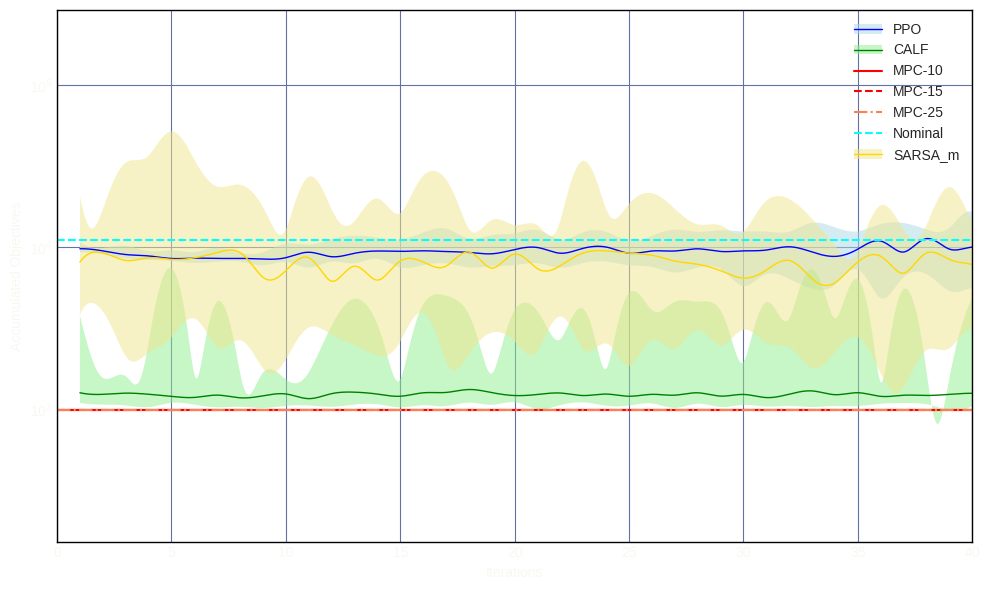

In [19]:
# %matplotlib inline

plt.clf()
plt.rcParams['axes.facecolor'] = 'white'
fig, ax = plt.subplots(figsize=(10, 6))
fig.patch.set_facecolor('white')
plt.style.use("seaborn-v0_8-whitegrid")

p1 = plot_cost_ic_learning_curve(ppo_df, ax, color="lightblue")
p2 = plot_cost_median_learning_curve(ppo_df, ax, color="blue")

p3 = plot_cost_ic_learning_curve(calf_df, ax, color="lightgreen", use_interpolate=True)
p4 = plot_cost_median_learning_curve(calf_df, ax, color="green")

p5_10 = ax.axhline(y=mpc_10_df.accumulative_objective.values[-1], color="red", linestyle="solid")
p5_15 = ax.axhline(y=mpc_15_df.accumulative_objective.values[-1], color="red", linestyle="dashed")
p5_25 = ax.axhline(y=mpc_25_df.accumulative_objective.values[-1], color="coral", linestyle="dashdot")

p6 = ax.axhline(y=nominal_df.accumulative_objective.values[-1], color="cyan", linestyle="dashed")

p7 = plot_cost_ic_learning_curve(sarsa_m_df, ax, color="khaki")
p8 = plot_cost_median_learning_curve(sarsa_m_df, ax, color="gold")

ax.set_yscale("log")

legend_info = {
    "PPO": (p1, p2),
    "CALF": (p3, p4),
    "MPC-10": p5_10,
    "MPC-15": p5_15,
    "MPC-25": p5_25,
    "Nominal": p6,
    "SARSA_m": (p7, p8),
}

legend = ax.legend(legend_info.values(), 
                   legend_info.keys(),
                   facecolor='white', framealpha=0.8)

frame = legend.get_frame()
frame.set_facecolor('green')
frame.set_edgecolor('red')

ax.set_xlim(0, 40)
plt.tight_layout()
fig.savefig("media/report_learning_curves.svg", 
            facecolor='w',
            bbox_inches = 'tight',
            pad_inches = 0)

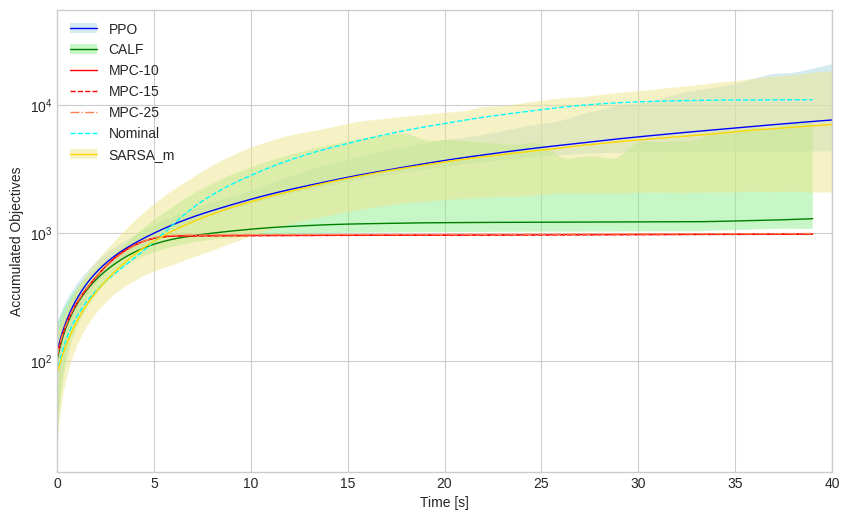

In [20]:
# %matplotlib inline

plt.clf()
plt.rcParams['axes.facecolor'] = 'white'
fig, ax = plt.subplots(figsize=(10, 6))
fig.patch.set_facecolor('white')
# ax.patch.set_facecolor('white')
plt.style.use("seaborn-v0_8-whitegrid")

p1 = plot_accum_cost_ic(ppo_df, ax, color="lightblue")
p2 = plot_accum_cost_median(ppo_df, ax, color="blue")

p3 = plot_accum_cost_ic(calf_df, ax, color="lightgreen")
p4 = plot_accum_cost_median(calf_df, ax, color="green")

p5_10 = plot_accum_cost_median(mpc_10_df, ax, color="red", linestyle="solid")
p5_15 = plot_accum_cost_median(mpc_15_df, ax, color="red", linestyle="dashed")
p5_25 = plot_accum_cost_median(mpc_25_df, ax, color="coral", linestyle="dashdot")

p6 = plot_accum_cost_median(nominal_df, ax, color="cyan", linestyle="dashed")

p7 = plot_accum_cost_ic(sarsa_m_df, ax, color="khaki")
p8 = plot_accum_cost_median(sarsa_m_df, ax, color="gold")

legend_info = {
    "PPO": (p1, p2),
    "CALF": (p3, p4),
    "MPC-10": p5_10,
    "MPC-15": p5_15,
    "MPC-25": p5_25,
    "Nominal": p6,
    "SARSA_m": (p7, p8),
}

legend = ax.legend(legend_info.values(), legend_info.keys())
frame = legend.get_frame()
frame.set_facecolor('white')

ax.set_yscale("log")
ax.set_xlim(0, 40)

fig.savefig("media/report_acc_costs.svg", 
            facecolor="white",
            bbox_inches = 'tight',
            pad_inches = 0)
# plt.show()
# frame

# Plot trajectories

1. Find the best checkpoint of CALF, SARSA_m, PPO
2. Run the best checkpoints with 25 seeds
3. Plot each of them in 1 subplot and with Nominal, 3x MPC

## Find the best CALF

/home/robosrv/huyhoang/regelum-playground/regelum_data/outputs/2024-08-29/12-33-12/0/.callbacks/HistoricalDataCallback/observations_actions_it_00015.h5


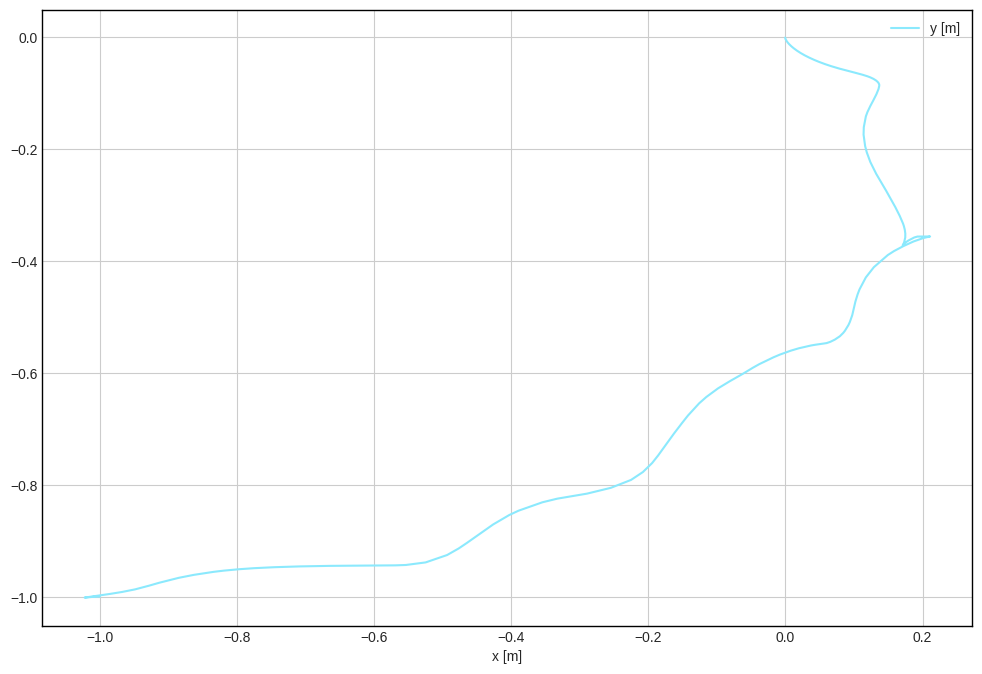

In [34]:
def find_best_exp_from_df(df, radius=0.15):
    df["goal_err"] = df.apply(lambda x: np.linalg.norm([x["x [m]"], x["y [m]"]]), axis=1)

    group_df = df.groupby(["absolute_path"]).last()
    group_df = group_df[group_df.goal_err < radius]

    index = group_df[group_df.accumulative_objective == group_df.accumulative_objective.min()].index
    best_exp = df.query(f"absolute_path == \"{index[0]}\"")

    return best_exp, index[0]

best_calf_df, best_calf_path = find_best_exp_from_df(calf_df)

print(best_calf_path)
best_calf_df.plot(x="x [m]", y="y [m]")

## Find the best of SARSA_m

/home/robosrv/huyhoang/regelum-playground/regelum_data/outputs/2024-08-29/17-12-47/0/.callbacks/HistoricalDataCallback/observations_actions_it_00044.h5


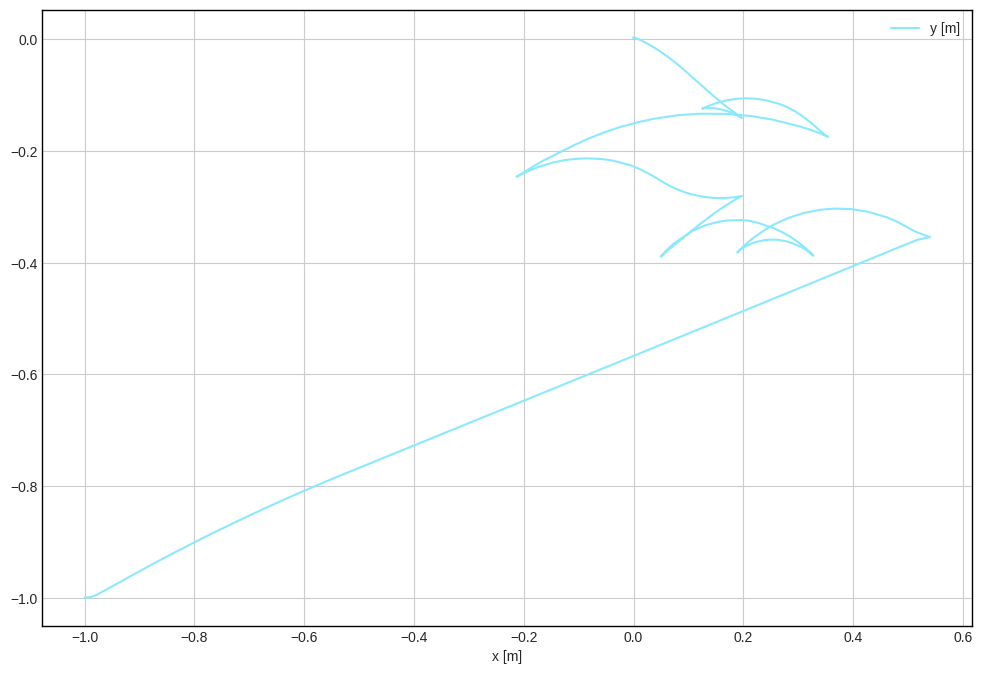

In [40]:
best_sarsa_df, best_sarsa_path = find_best_exp_from_df(sarsa_m_df, radius=0.05)

print(best_sarsa_path)
best_sarsa_df.plot(x="x [m]", y="y [m]")

## Find the best of PPO

/home/robosrv/huyhoang/regelum-playground/regelum_data/outputs/2024-08-27/23-00-48/0/.callbacks/HistoricalDataCallback/observations_actions_it_00053.h5


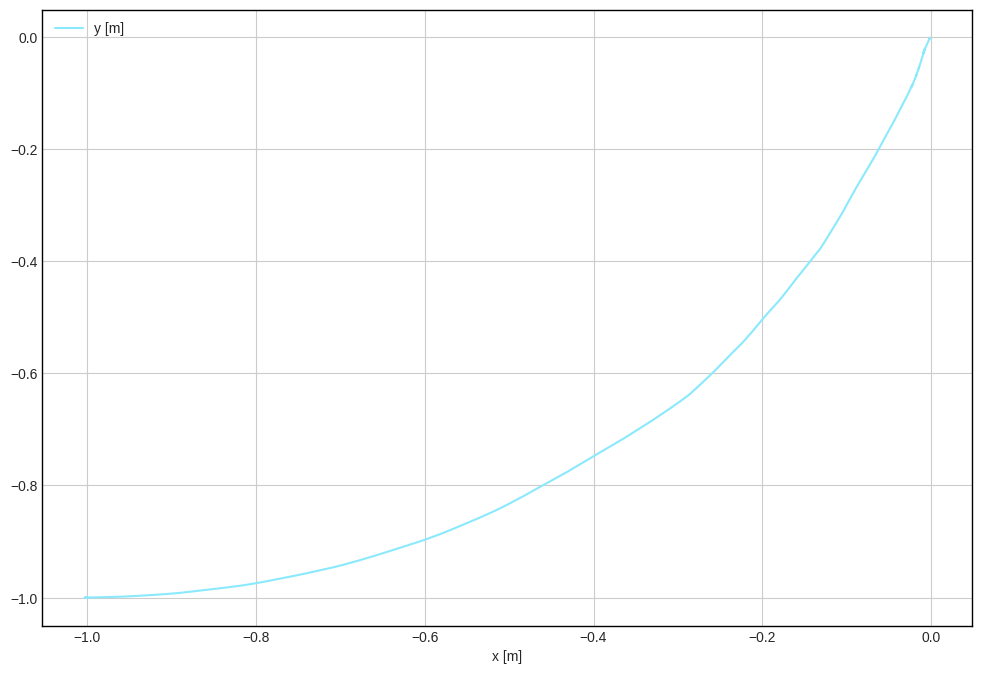

In [35]:
best_ppo_df, best_ppo_path = find_best_exp_from_df(ppo_df, radius=0.01)

print(best_ppo_path)
best_ppo_df.plot(x="x [m]", y="y [m]")

## Load Runs with best checkpoints

In [24]:
# CALF with spot penalty 1e3
start_datetime_str = "2024-08-30 08-59-43"
end_datetime_str = "2024-08-30 09-16-52"

# CALF with spot penalty 1e2
start_datetime_str = "2024-08-30 09-19-44"
end_datetime_str = "2024-08-30 09-38-13"
best_calf_df = get_df_from_datetime_range(start_datetime_str, end_datetime_str, decay_rate=DECAY_RATE)

start_datetime_str = "2024-08-30 09-45-55"
end_datetime_str = "2024-08-30 10-09-28"
best_sarsa_df = get_df_from_datetime_range(start_datetime_str, end_datetime_str, decay_rate=DECAY_RATE)

start_datetime_str = "2024-08-26 11-36-05"
end_datetime_str = "2024-08-26 12-00-06"

start_datetime_str = "2024-08-30 10-24-09"
end_datetime_str = "2024-08-30 10-48-10"
best_ppo_df = get_df_from_datetime_range(start_datetime_str, end_datetime_str, decay_rate=DECAY_RATE)

## In this case, PPO stop early
# start_datetime_str = "2024-08-19 15-23-09"
# end_datetime_str = "2024-08-19 15-23-09"
# best_ppo_df = get_df_from_datetime_range(start_datetime_str, end_datetime_str, decay_rate=DECAY_RATE)

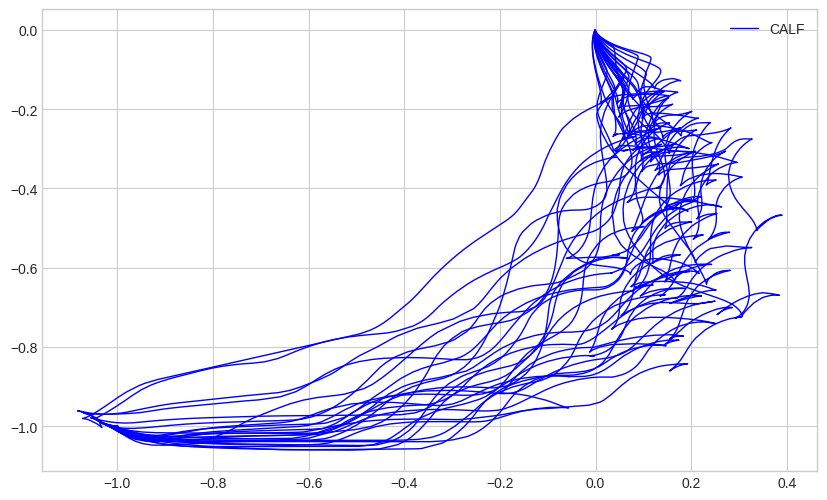

In [25]:
fig, ax = plt.subplots(figsize=(10, 6))

def plot_trajectories(df, ax, color="blue", linestyle="solid"):
    paths = df.absolute_path.unique()
    tmp_df = df.set_index("absolute_path")
    for p in paths:
        _X = tmp_df.loc[p]["x [m]"]
        _Y = tmp_df.loc[p]["y [m]"]
        pl = ax.plot(_X, _Y, color=color, lw=1, zorder=5, linestyle=linestyle)

    return pl[0]

calf_pl = plot_trajectories(best_calf_df, ax)
legend_info = {
    "CALF": calf_pl,
}

legend = ax.legend(legend_info.values(), 
                   legend_info.keys(),
                   facecolor='white', framealpha=0.8)

## Plot

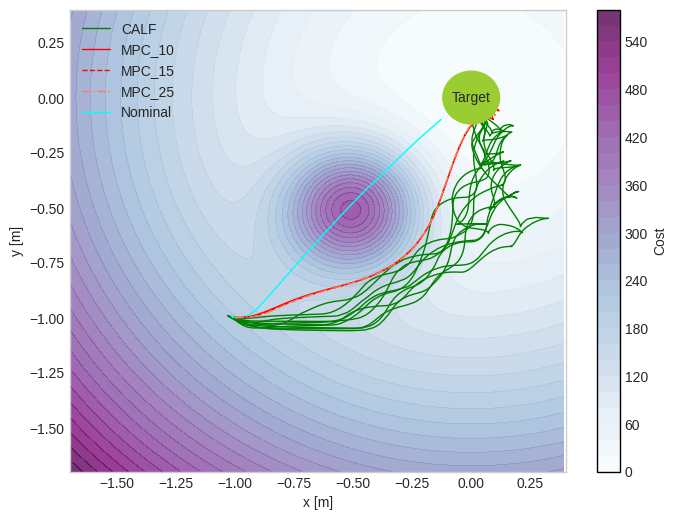

In [26]:
# %matplotlib inline
def plot_chosen_best_checkpoint(chosen_df, name, color, linestyle, target_r=0.1):
    plt.clf()
    fig, ax = plt.subplots(figsize=(8, 6))

    plt.figure(facecolor='white')  # Set figure background color
    fig.patch.set_facecolor('white')
    plt.rcParams.update({"figure.figsize" : (12, 8),
                        "axes.facecolor" : "white",
                        "axes.edgecolor":  "black"})

    x_lim = y_lim = [-1.7, 0.4]
    X, Y, Z = get_cost_map(x_lim, y_lim)

    cs = ax.contourf(X, Y, Z, alpha=0.8, levels=35, cmap="BuPu")
    cs.cmap.set_over('red')
    cs.cmap.set_under('blue')
    cs.changed()

    # Make a colorbar for the ContourSet returned by the contourf call.
    cbar = fig.colorbar(cs)
    cbar.ax.set_ylabel('Cost')

    chosen_pl = plot_trajectories(chosen_df, ax, color, linestyle)
    nominal_pl = plot_trajectories(nominal_df, ax, "cyan")
    mpc_10_pl = plot_trajectories(mpc_10_df, ax, color="red", linestyle="solid")
    mpc_15_pl = plot_trajectories(mpc_15_df, ax, color="red", linestyle="dashed")
    mpc_25_pl = plot_trajectories(mpc_25_df, ax, color="coral", linestyle="dashdot")

    legend_info = {
        name: chosen_pl,
        "MPC_10": mpc_10_pl,
        "MPC_15": mpc_15_pl,
        "MPC_25": mpc_25_pl,
        "Nominal": nominal_pl,
    }

    legend = ax.legend(legend_info.values(), 
                    legend_info.keys(),
                    facecolor='white', framealpha=0.8)

    ax.annotate(text="Target", xy=(0, 0), ha='center', va='center', zorder=15)
    goal_circle = plt.Circle((0, 0), target_r, color="yellowgreen", zorder=10)
    ax.add_artist(goal_circle)

    ax.grid()
    ax.set_xlim(*x_lim)
    ax.set_ylim(*y_lim)
    ax.set_xlabel("x [m]")
    ax.set_ylabel("y [m]")

    fig.savefig(f"media/report_{name}_trajectory.svg", 
                facecolor="white",
                bbox_inches = 'tight',
                pad_inches = 0)

group_df = best_calf_df.groupby(["absolute_path"]).last()
top_10_abs_path = group_df.sort_values(by="accumulative_objective").iloc[:10, :].index
top_10_df = best_calf_df[best_calf_df["absolute_path"].isin(top_10_abs_path)]
plot_chosen_best_checkpoint(top_10_df, "CALF", "green", linestyle="solid", target_r=0.12)

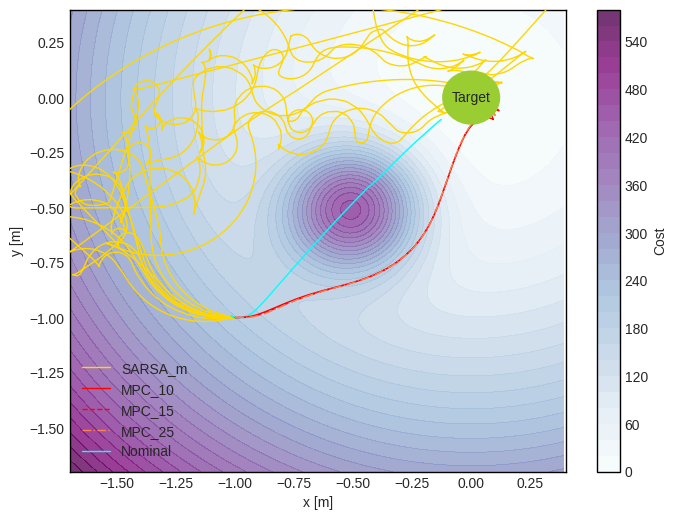

In [27]:
best_sarsa_df["goal_err"] = best_sarsa_df.apply(lambda x: np.linalg.norm([x["x [m]"], x["y [m]"]]), axis=1)
group_df = best_sarsa_df.groupby(["absolute_path"]).last()
# top_10_abs_path = group_df.sort_values(by="accumulative_objective").iloc[:10, :].index
top_10_abs_path = group_df.sort_values(by="goal_err").iloc[:10, :].index
top_10_sarsa_df = best_sarsa_df[best_sarsa_df["absolute_path"].isin(top_10_abs_path)]
plot_chosen_best_checkpoint(top_10_sarsa_df, "SARSA_m", "gold", linestyle="solid", target_r=0.12)

In [28]:
best_sarsa_df.absolute_path.nunique()

25

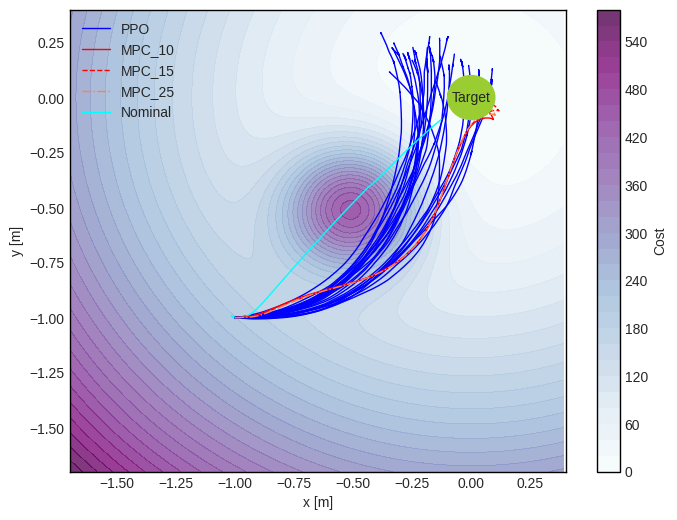

In [29]:
plot_chosen_best_checkpoint(best_ppo_df, "PPO", "blue", linestyle="solid")

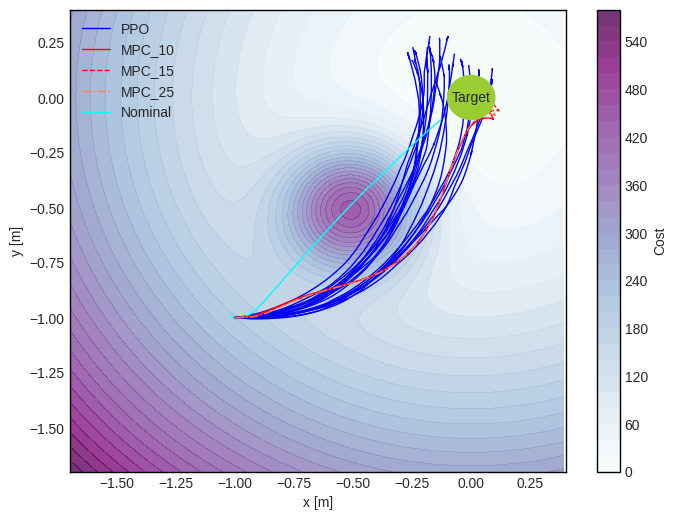

In [30]:
best_ppo_df["goal_err"] = best_ppo_df.apply(lambda x: np.linalg.norm([x["x [m]"], x["y [m]"]]), axis=1)

group_df = best_ppo_df.groupby(["absolute_path"]).last()
top_10_abs_path = group_df.sort_values(by="goal_err").iloc[:20, :].index
top_10_ppo_df = best_ppo_df[best_ppo_df["absolute_path"].isin(top_10_abs_path)]
plot_chosen_best_checkpoint(top_10_ppo_df, "PPO", "blue", linestyle="solid", target_r=0.1)

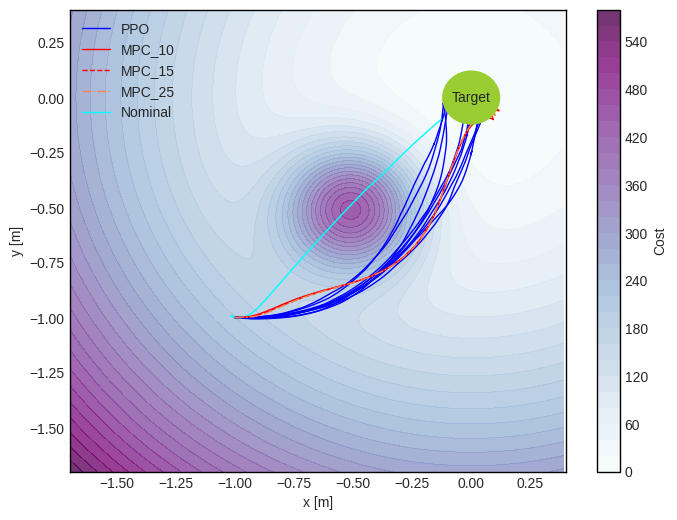

In [31]:
group_df = best_ppo_df.groupby(["absolute_path"]).agg({"goal_err": "min"})
top_10_abs_path = group_df.sort_values("goal_err").iloc[:10, :].index
tmp_df = best_ppo_df.set_index("absolute_path")

modified_dfs = []
for p in top_10_abs_path:
    iter_df = tmp_df.loc[p].reset_index()
    a = iter_df["goal_err"].argmin()
    iter_df = iter_df.truncate(after=iter_df["goal_err"].argmin())
    modified_dfs.append(iter_df.copy())

modified_dfs = pd.concat(modified_dfs)
plot_chosen_best_checkpoint(modified_dfs, "PPO", "blue", linestyle="solid", target_r=0.12)

In [32]:
best_ppo_df["goal_err"] = best_ppo_df.apply(lambda x: np.linalg.norm([x["x [m]"], x["y [m]"]]), axis=1)
best_ppo_df

,time,running_objective,current_value,episode_id,iteration_id,velocity [m/s],angular velocity [rad/s],x [m],y [m],angle [rad],absolute_path,objective_value,accumulative_objective,experiment_path,goal_err
0,0.000,200.000000,20.000000,1,1,0.028739,0.115651,-1.000000,-1.000000,0.000100,/home/robosrv/huyhoang/regelum-playground/rege...,200.768103,20.076810,/home/robosrv/huyhoang/regelum-playground/rege...,1.414214
1,0.100,199.524820,39.253369,1,1,0.067106,0.110426,-0.997745,-0.999876,0.009736,/home/robosrv/huyhoang/regelum-playground/rege...,200.315959,40.108406,/home/robosrv/huyhoang/regelum-playground/rege...,1.412532
2,0.205,199.177479,57.766732,1,1,0.132145,0.095494,-0.996021,-0.999858,0.009519,/home/robosrv/huyhoang/regelum-playground/rege...,199.985942,60.107000,/home/robosrv/huyhoang/regelum-playground/rege...,1.411302
3,0.309,197.390186,75.445861,1,1,0.071597,0.048497,-0.987065,-0.999802,0.003812,/home/robosrv/huyhoang/regelum-playground/rege...,198.293406,79.936341,/home/robosrv/huyhoang/regelum-playground/rege...,1.404956
4,0.409,195.036158,92.302082,1,1,0.052845,0.092126,-0.975103,-0.999767,0.006045,/home/robosrv/huyhoang/regelum-playground/rege...,196.079580,99.544299,/home/robosrv/huyhoang/regelum-playground/rege...,1.396553
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,49.506,16.060283,496.732924,1,1,-0.015055,-0.068003,-0.285786,0.193456,2.037242,/home/robosrv/huyhoang/regelum-playground/rege...,12.459594,4705.550473,/home/robosrv/huyhoang/regelum-playground/rege...,0.345108
480,49.609,16.266772,496.732924,1,1,0.069752,0.015135,-0.287158,0.196184,2.042538,/home/robosrv/huyhoang/regelum-playground/rege...,12.622895,4706.812762,/home/robosrv/huyhoang/regelum-playground/rege...,0.347776
481,49.711,16.394657,496.732924,1,1,-0.013621,-0.023953,-0.287688,0.197197,2.056596,/home/robosrv/huyhoang/regelum-playground/rege...,12.685379,4708.081300,/home/robosrv/huyhoang/regelum-playground/rege...,0.348785
482,49.847,16.543673,496.732924,1,1,0.031959,0.013182,-0.289173,0.200040,2.044504,/home/robosrv/huyhoang/regelum-playground/rege...,12.862687,4709.367569,/home/robosrv/huyhoang/regelum-playground/rege...,0.351620


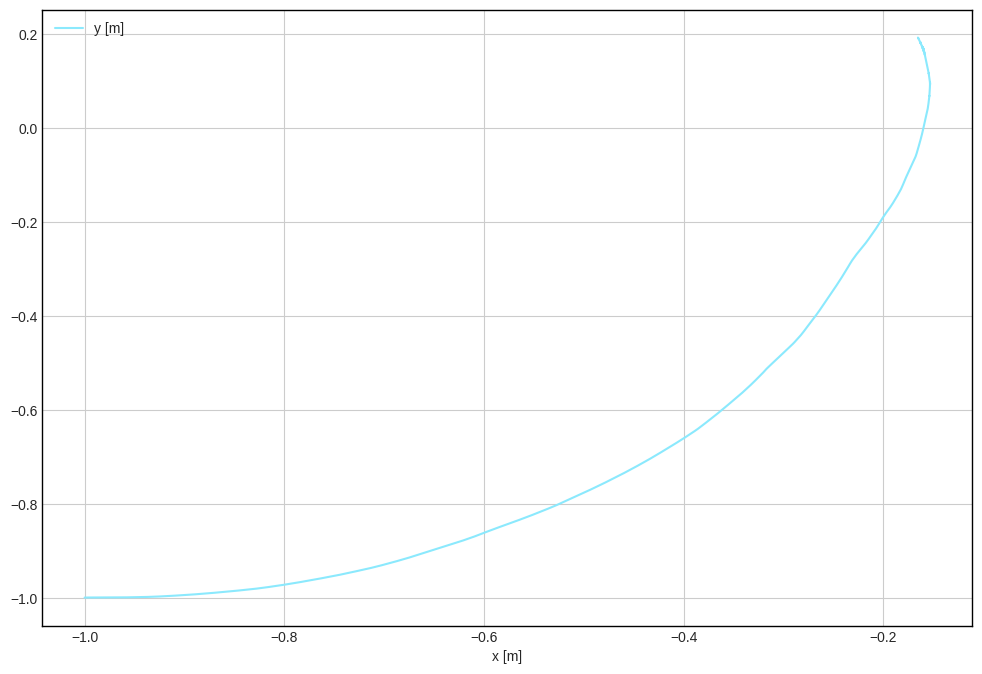

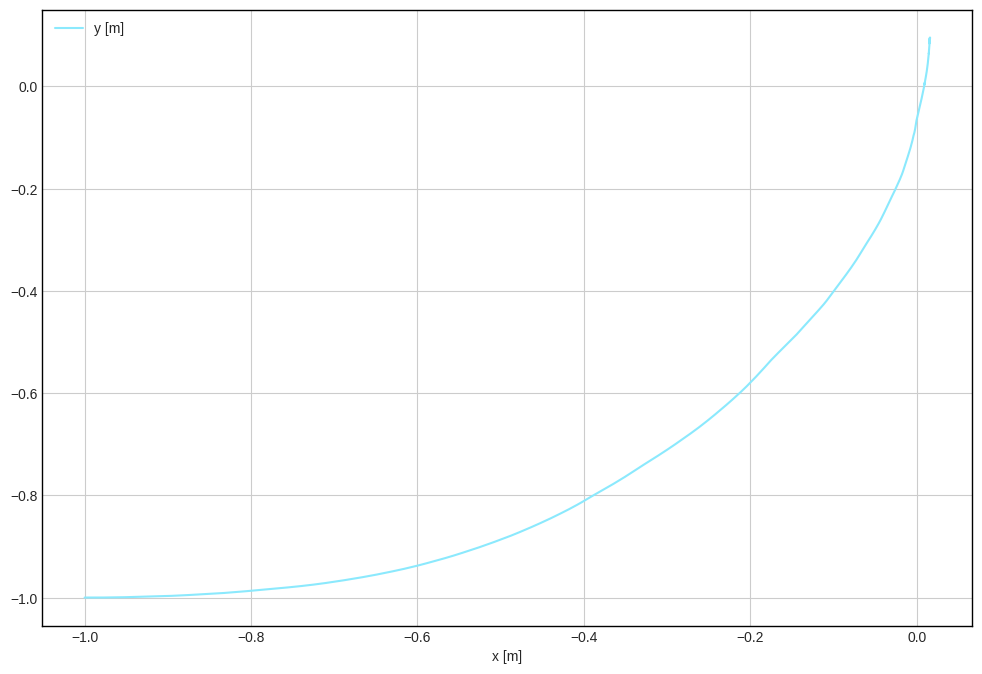

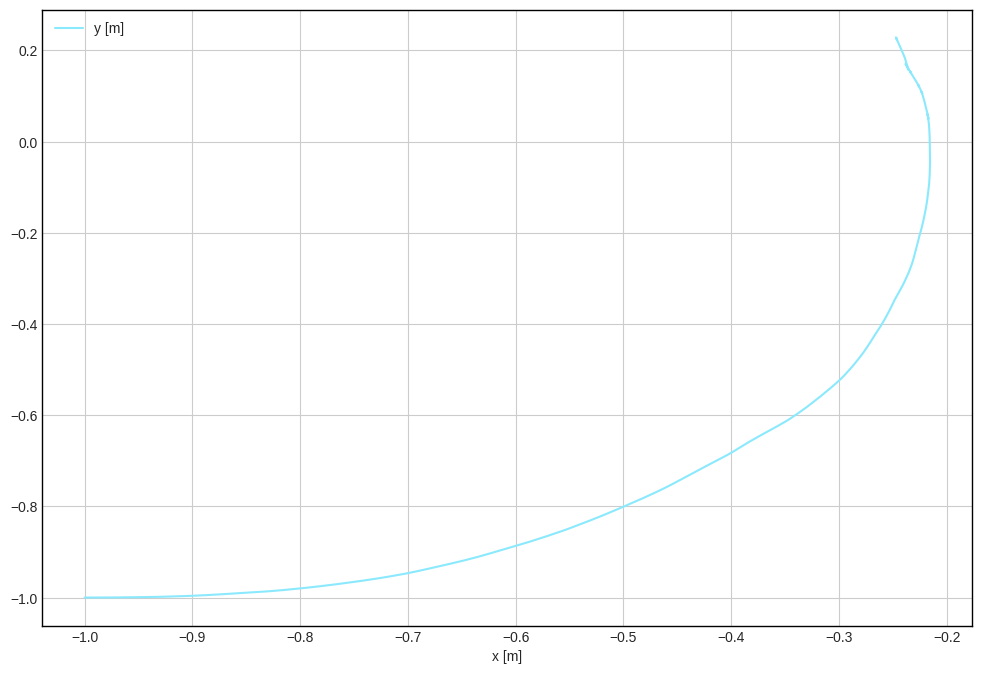

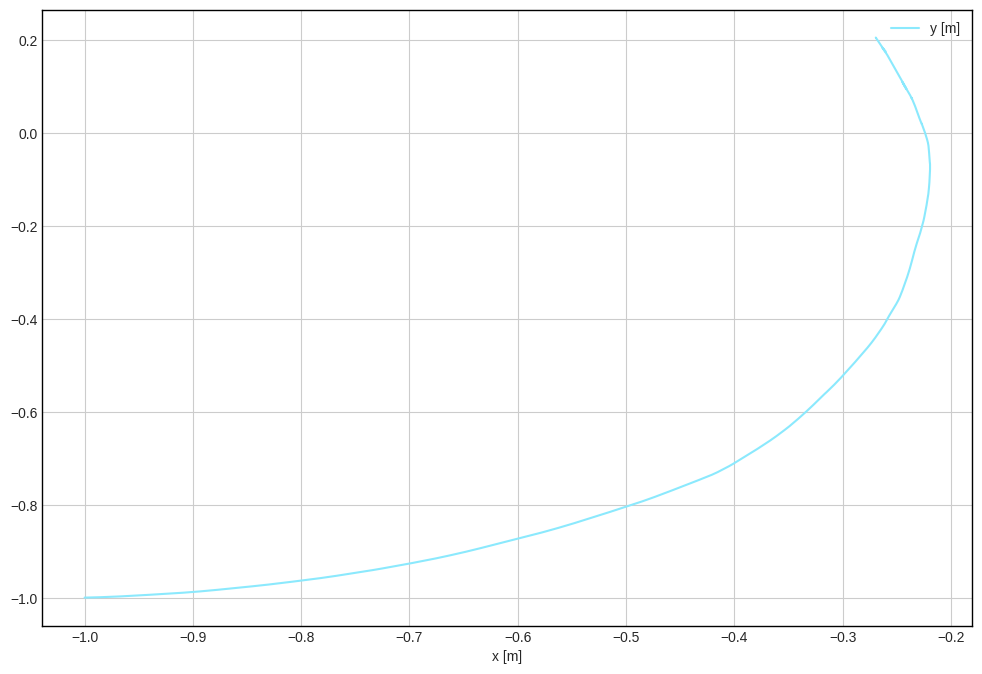

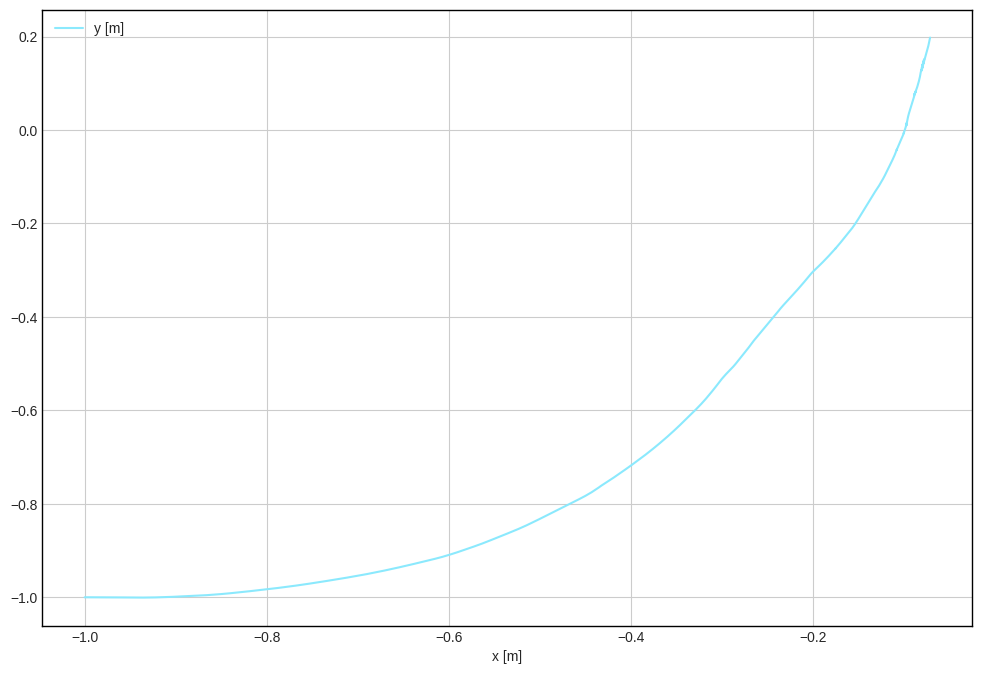

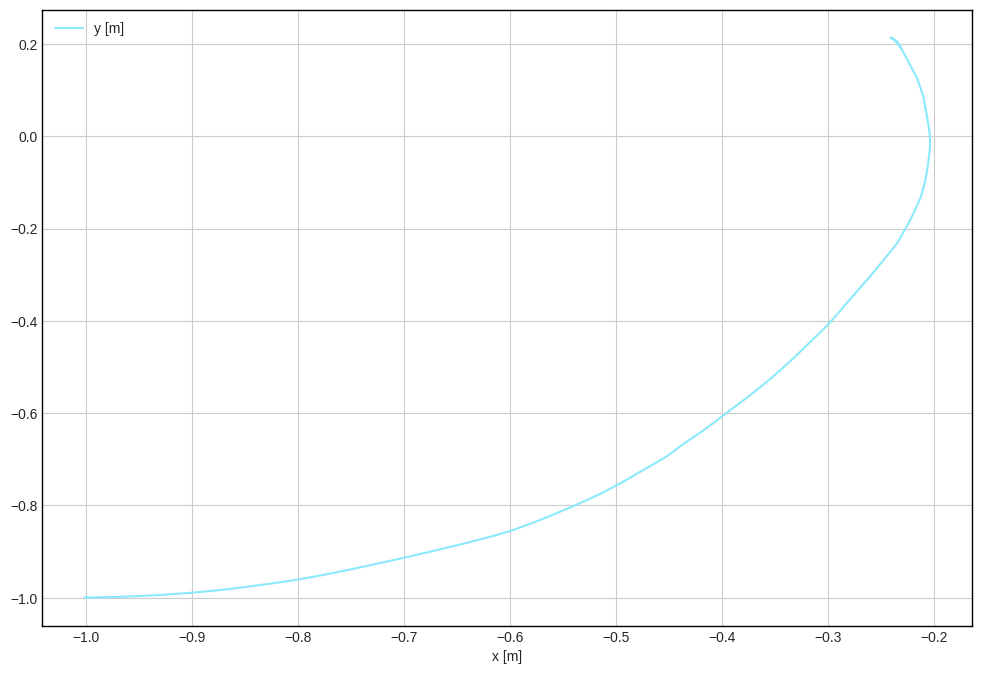

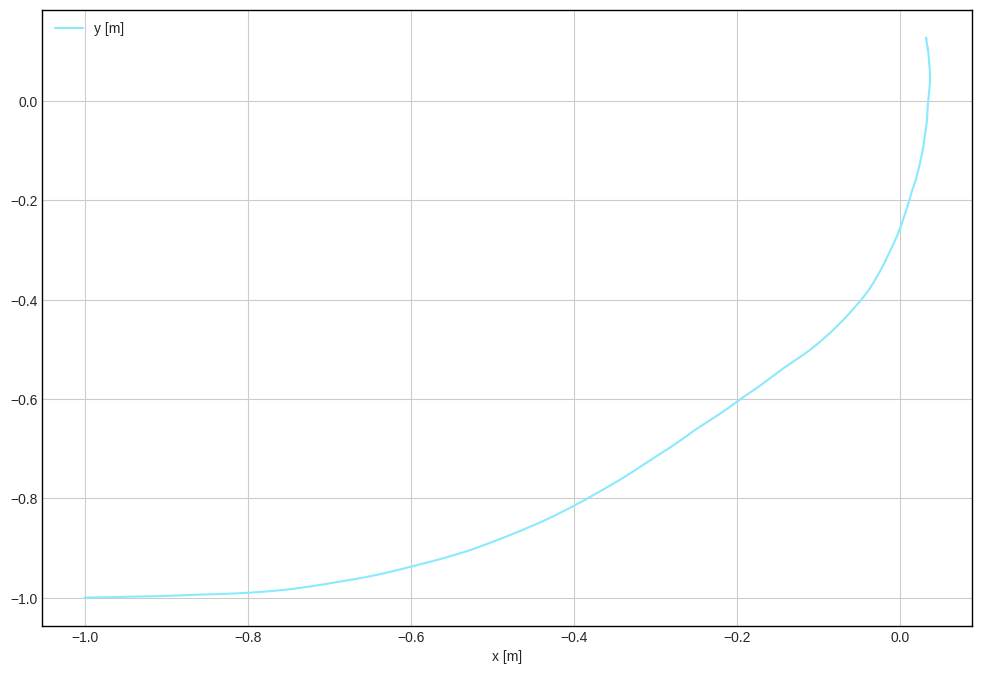

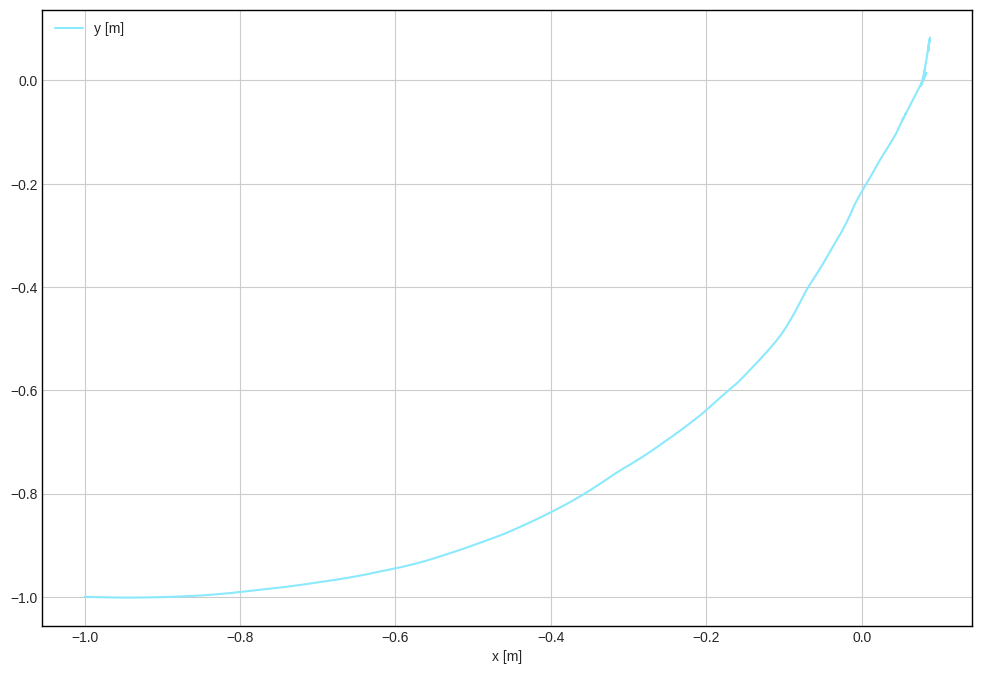

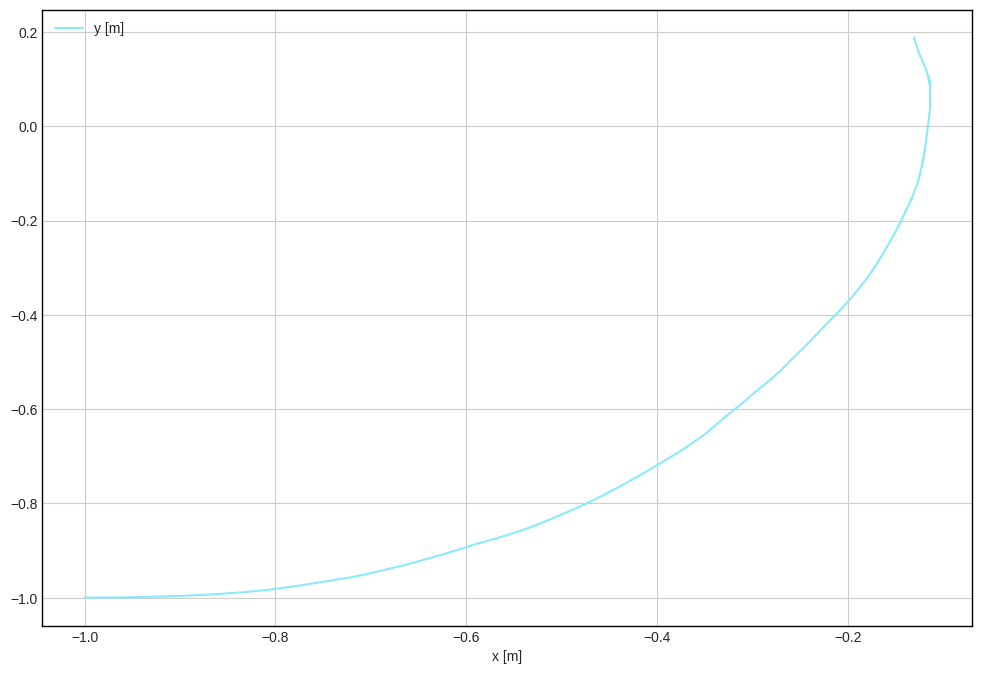

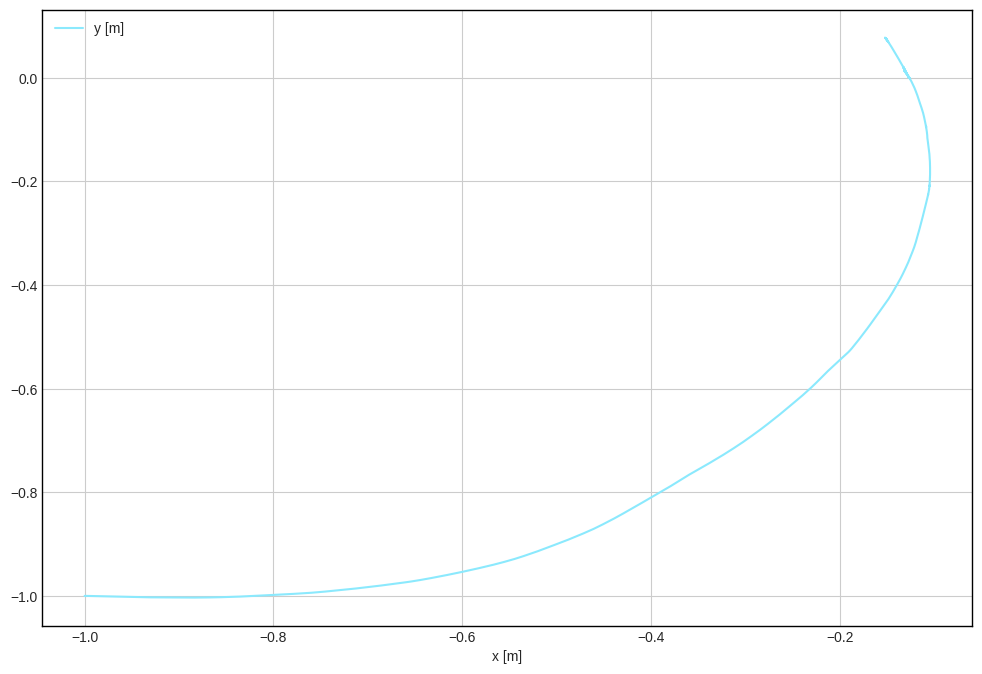

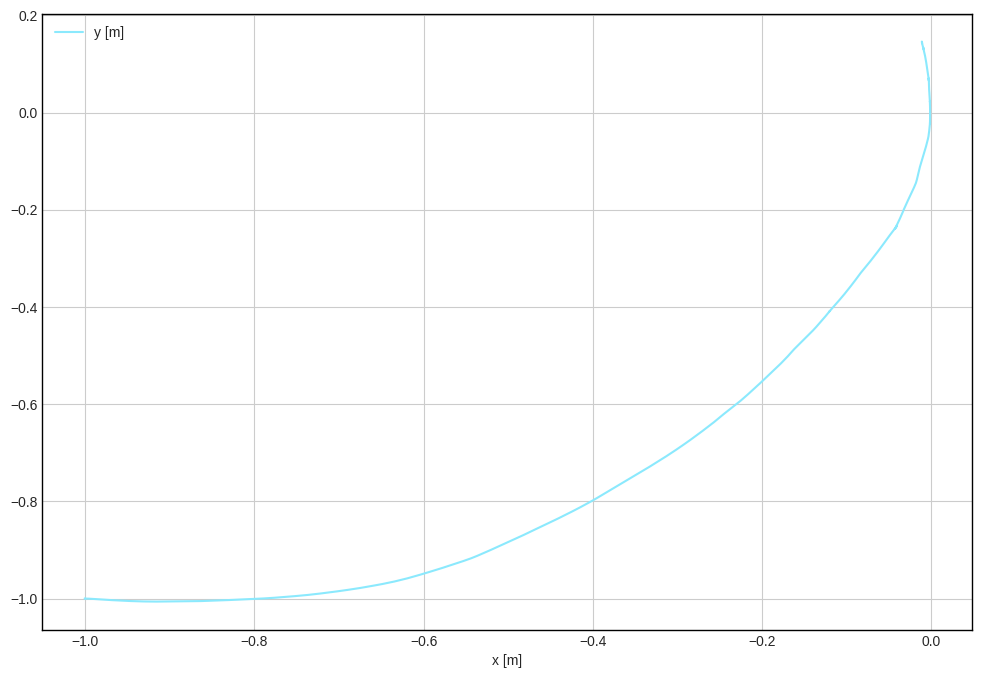

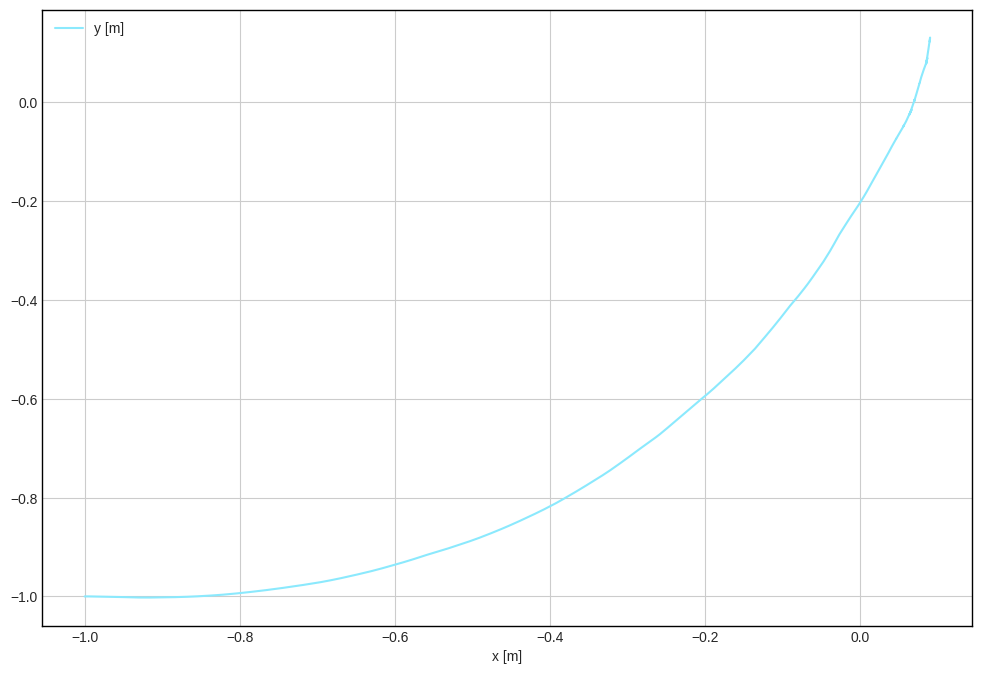

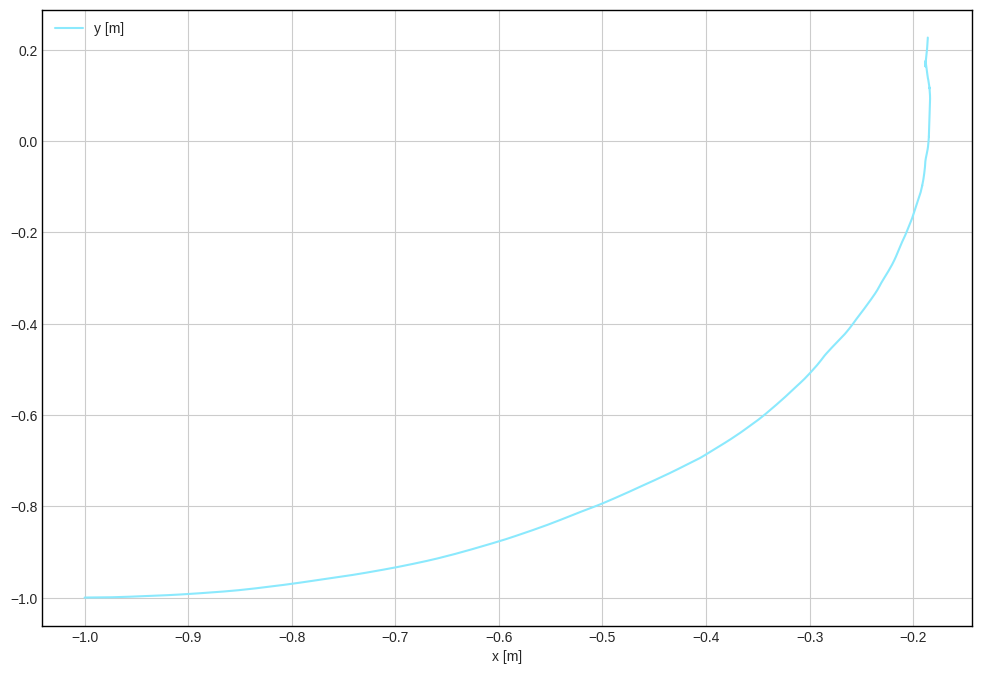

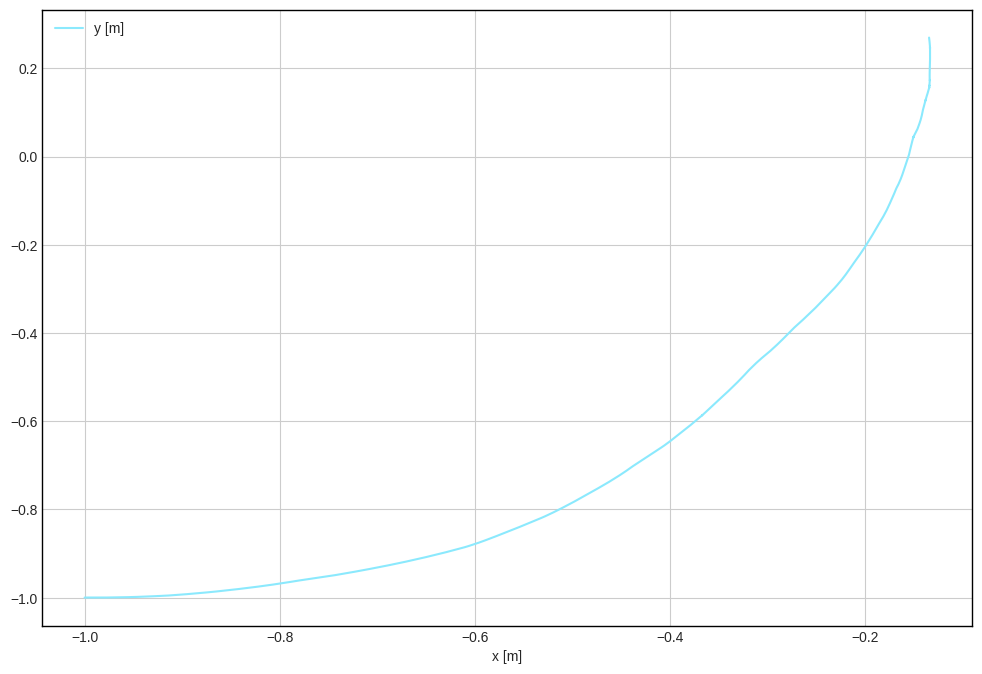

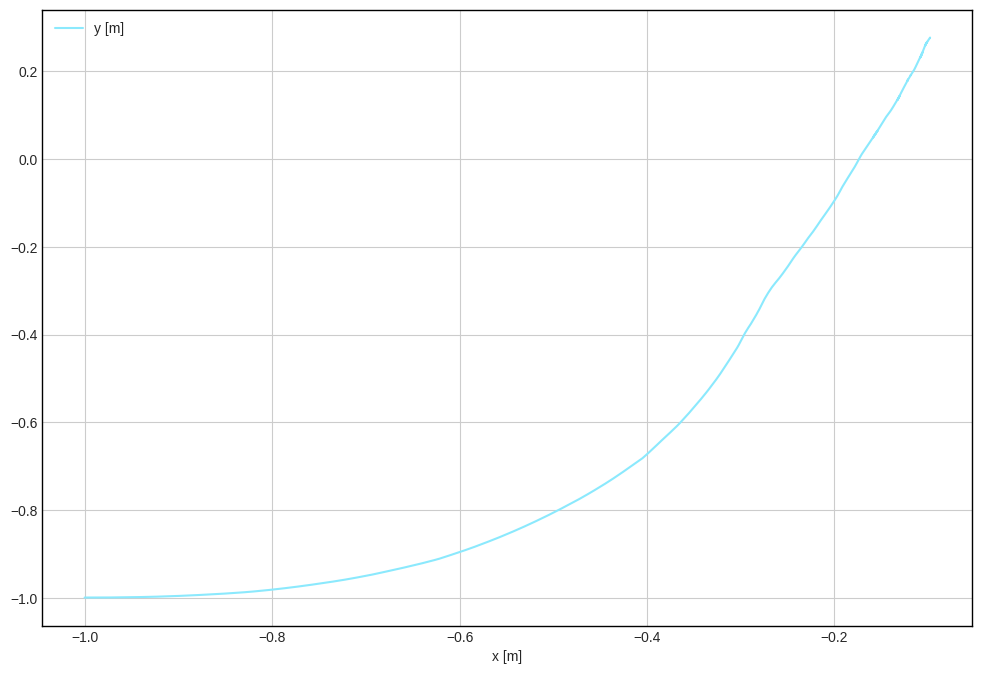

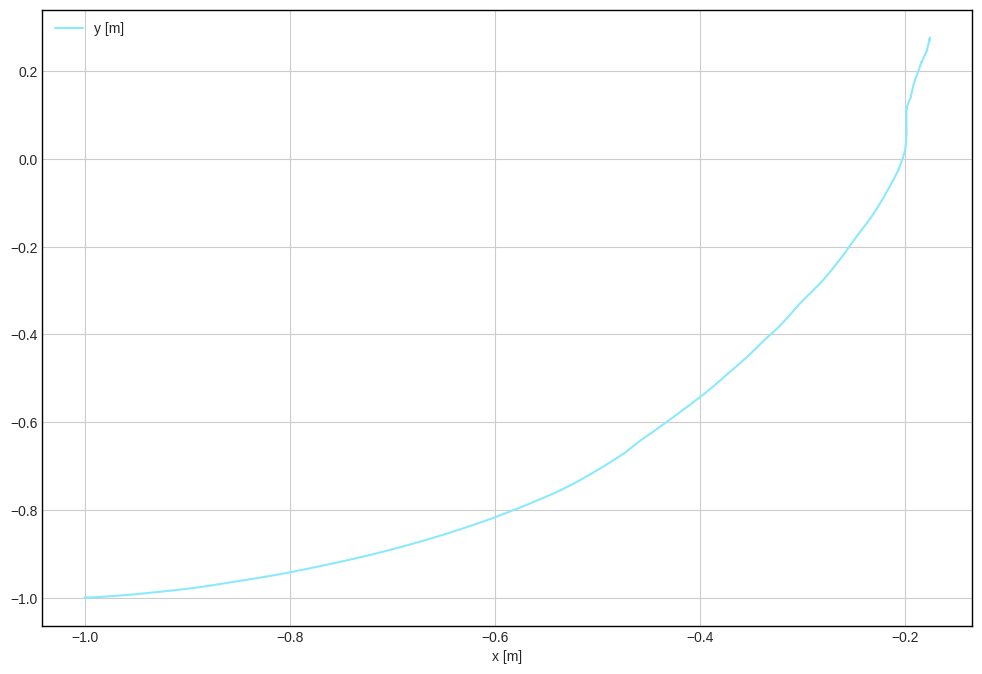

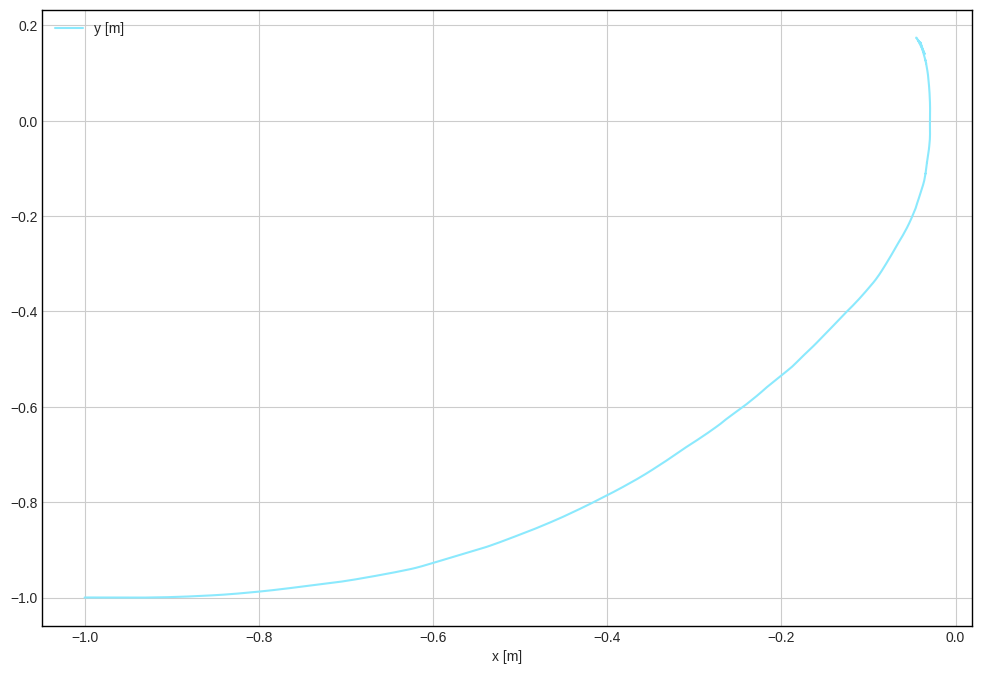

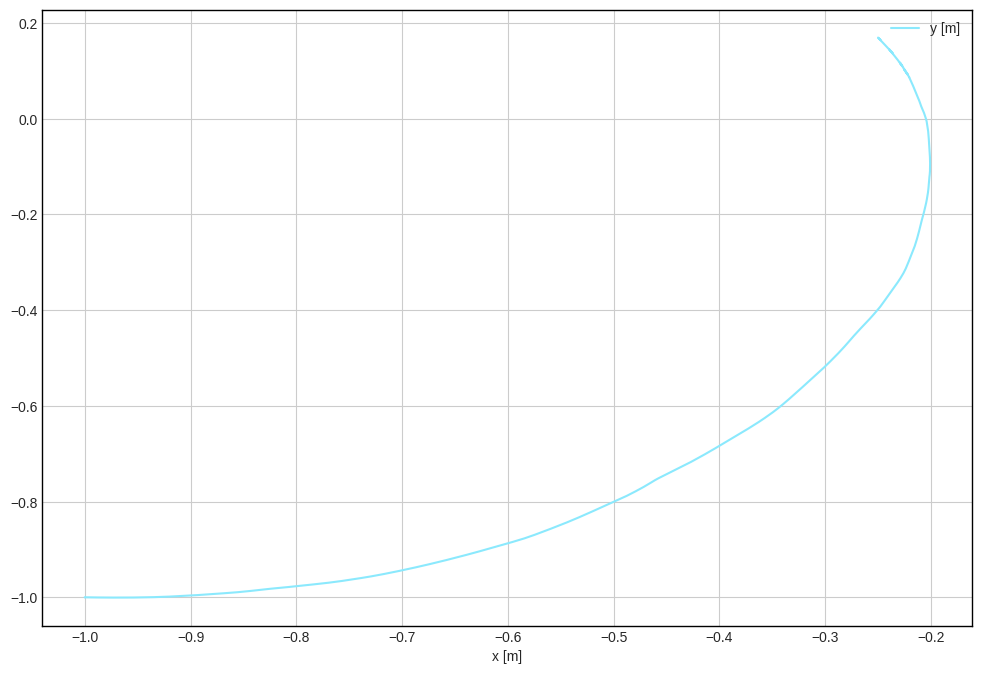

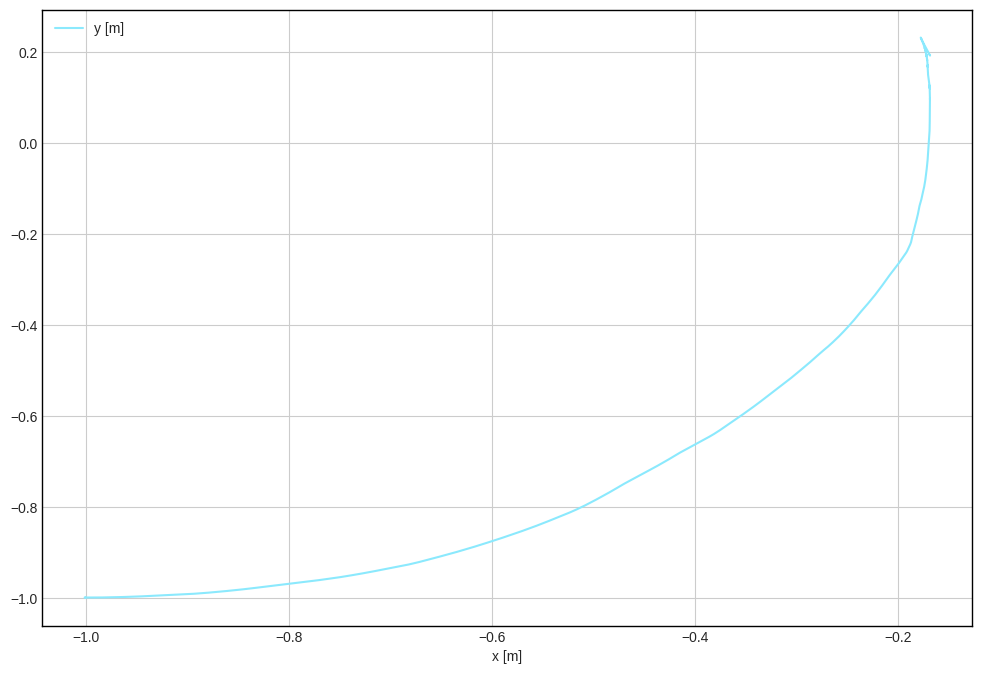

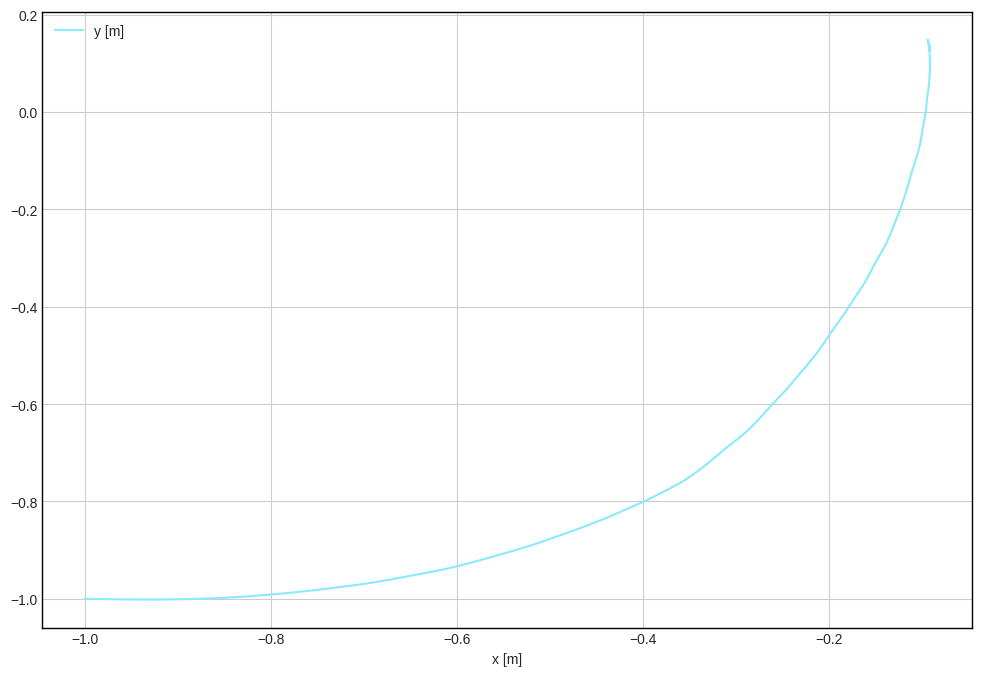

In [33]:
# top_10_ppo_df.absolute_path.nunique()
for p in list(top_10_ppo_df.absolute_path.unique()):
    top_10_ppo_df[top_10_ppo_df.absolute_path == p].plot(x="x [m]", y="y [m]")